# Connectivity across groups

This notebook contains the code for the descriptive analysis of the connectivity across experimental groups: AVGP and NVGP.


In [4]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path
import xarray as xr
import scipy.stats as stats
import numpy as np
from src.acnets.pipeline import ConnectivityPipeline, ConnectivityVectorizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (GridSearchCV, StratifiedShuffleSplit,
                                     cross_val_score, learning_curve,
                                     permutation_test_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from tqdm.auto import tqdm
from IPython.display import clear_output

from src.acnets.pipeline import Parcellation

import seaborn as sns
import matplotlib.pyplot as plt

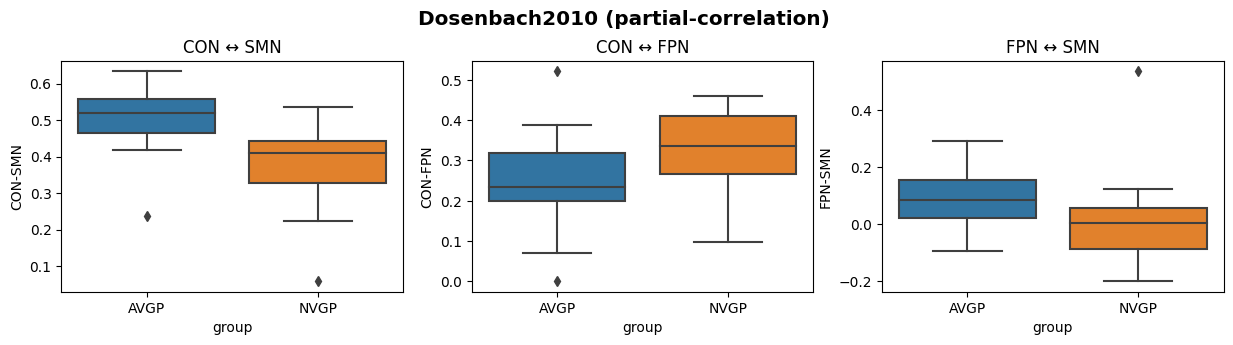

In [22]:
pipe = ConnectivityPipeline(atlas='dosenbach2010',
                            kind='partial correlation',
                            timeseries_aggregation='network')
pipe.fit_transform(None)
data = pipe.dataset_

def shorten_network_name(name):
    return {
        'cingulo-opercular': 'CON',
        'fronto-parietal': 'FPN',
        'sensorimotor': 'SMN',
    }[name]

def plot_connectivity_dist(data, src, dst, plot_kde=True, box_ax=None):

    avgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('AVGP')])
    nvgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('NVGP')])

    avgp_conn = avgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)
    nvgp_conn = nvgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)

    src = shorten_network_name(src)
    dst = shorten_network_name(dst)
    
    conn_name = f'{src}-{dst}'

    plot_data = pd.concat([
        pd.DataFrame(avgp_conn.values, columns=[conn_name]).assign(group='AVGP'),
        pd.DataFrame(nvgp_conn.values, columns=[conn_name]).assign(group='NVGP')
    ]).reset_index(drop=True)


    if plot_kde:
        fig, (kde_ax, box_ax) = plt.subplots(1, 2, figsize=(10, 3))

        sns.kdeplot(data=plot_data, x=conn_name, hue='group', cut=0, ax=kde_ax)

    sns.boxplot(data=plot_data, x='group', y=conn_name, ax=box_ax)
    # from statannotations.Annotator import Annotator
    # Annotator(ax=axes[1]).add_stat_annotation(12, 8, 'AVGP', 'NVGP', test='Mann-Whitney', loc='inside', verbose=2)

    box_ax.set_title(f'{src} \N{left right arrow} {dst}')

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

plot_connectivity_dist(data, 'cingulo-opercular', 'sensorimotor', plot_kde=False, box_ax=axes[0])
# DEBUG to make sure connectivity is symmetric
# plot_connectivity_dist(data, 'sensorimotor', 'cingulo-opercular')
plot_connectivity_dist(data, 'cingulo-opercular', 'fronto-parietal', plot_kde=False, box_ax=axes[1])
plot_connectivity_dist(data, 'fronto-parietal', 'sensorimotor', plot_kde=False, box_ax=axes[2])

plt.suptitle(f'Dosenbach2010 (partial-correlation)', y=1.05, fontsize='x-large', fontweight='bold')
plt.show()

## T-test

Here, we compare the means of three connectivities (CON-SMN, FPN-SMN, CON-FPN) of two groups. The null hypothesis is that the two groups have the same mean. The alternative hypothesis is that the two groups have different means.

In [ ]:
import pingouin as pg

avgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('AVGP')])
nvgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('NVGP')])

def report_ttest(src, dst, alternative='two-sided'):
        
    avgp_conn = avgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)
    nvgp_conn = nvgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)

    # con-smn (H1: AVGP > NVGP)
    results = pg.ttest(avgp_conn.values, nvgp_conn.values,
                       paired=False, correction=True, alternative=alternative)

    h_sign = {
        'two-sided': '!=',
        'greater': '>',
        'less': '<'
    }[alternative]

    src = shorten_network_name(src)
    dst = shorten_network_name(dst)

    print(f'{src} \N{left right arrow} {dst} (H1: AVGP {h_sign} NVGP)')
    display(results)

report_ttest('cingulo-opercular', 'sensorimotor', alternative='greater')
report_ttest('fronto-parietal', 'sensorimotor', alternative='greater')
report_ttest('cingulo-opercular', 'fronto-parietal', alternative='two-sided')


CON ↔ SMN (H1: AVGP > NVGP)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.190992,28.129259,greater,0.001736,"[0.06, inf]",1.128186,23.742,0.929612


FPN ↔ SMN (H1: AVGP > NVGP)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.748512,25.066664,greater,0.046307,"[0.0, inf]",0.618192,2.112,0.525532


CON ↔ FPN (H1: AVGP != NVGP)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.5065,29.802747,two-sided,0.142466,"[-0.15, 0.02]",0.532628,0.791,0.308304
